# Denoising Autoencoder 

#### What is the goal of this project? 
Ultimately, we could use denoising autoencoders in order to 
The input of the denoising autoencoder would be sound files that are noisy and then its output would be cleaner noise. Denoising autoencoders, as the name suggests, are great for removing noise from signals and this could potentially be used as a preprocessing filter.

#### What do we need? 
- Dataset that is purposefully noisy 
- Probably some dataset we are already familiar with such as Xeno Canto 

#### Sources to look at: 
- [Meeting Notes from Irina](https://docs.google.com/document/d/1-5w7-DAHdwM9C4aDyG6Ps0XwYxnfhDWRywiAYrnpmJs/edit) 
- [Autoencoder Neural Network: Image Denoising](https://debuggercafe.com/autoencoder-neural-network-application-to-image-denoising/) 
- [Denoising Autoencoder](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_14_02_auto_encode.ipynb) 
- [Denoising Autoencoder Youtube](https://www.youtube.com/watch?v=4bTSu6_fucc) 

In [1]:
# IMPORT 
import os 
import pydub
from pydub import AudioSegment
from scipy.io import wavfile
import samplerate
import librosa
from scipy import signal
import numpy as np
from librosa import feature
from librosa import filters
from scipy.signal import butter, filtfilt
from scipy import ndimage
import librosa.display
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pydub
from pydub import AudioSegment
import tempfile
import soundfile as sf
import scipy
from scipy.io.wavfile import write
import sounddevice as sd

## Load in the audio data

In [2]:
def convert_mp3_to_wav(mp3_path, sr=44100, mono=True, overwrite=False, dtype='float32'): 
    # Need to change sample rate to 44.1kHz if using audiomoths
    # since mono=True by default, unless you pass mono=False, 
    # this function will save the wav as mono
#     print("entering convert_mp3_to_wav")
    """
    Parts of code from 
    https://github.com/bill317996/Audio-to-midi/blob/master/cfp.py
    """
    
#     warnings.warn("deprecated", DeprecationWarning)
    
    # in case there is an .MP3
    assert mp3_path.lower().endswith('.mp3'), 'filename indicates not mp3'
    wav_path_to_write = os.path.splitext(mp3_path)[0] + '.wav'
    if not overwrite and os.path.exists(wav_path_to_write):
        return
    
    mp3 = AudioSegment.from_file(mp3_path)
    
    _, temp_path = tempfile.mkstemp() 
    mp3.export(temp_path, format='wav')
    del mp3
    x, fs = sf.read(temp_path)
    os.remove(temp_path)
    
    if mono and len(x.shape)>1: 
        x = np.mean(x, axis = 1) 
    if sr:
        x = scipy.signal.resample_poly(x, sr, fs)
        fs = sr 
    x = x.astype(dtype)
    #write(wav_path_to_write, fs, x)
    return x, fs  

def find_n_second_multiples_and_filenames(dir_path, n, des_sr): 
    """ 
    dir_path (path): path of a directory with desired files
    n (int): split data into n-second clips
    # Note that this function also resamples!
    """
    wav_data = []
    allfilenames = []
    timestamp = []

    for filename in os.listdir(dir_path):
        filepath = os.path.join(dir_path, filename)
        print(filepath)
        
        if filepath == ".DS_Store": 
            pass 
        elif filename.endswith(".mp3") or filename.endswith(".MP3"): 
            data, sr = convert_mp3_to_wav(filepath)
            print("sr", sr)
            
        elif filename.endswith(".wav") or filename.endswith(".WAV"):
            sr, data = wavfile.read(filepath)
            print(data)
            # comment out previous for no resampling
            # data = samplerate.resample(data, des_sr/sr, 'sinc_best')
            data = scipy.signal.decimate(data, 9) # 384000/44100
            sr = des_sr
            
        num_samples_in_n_seconds =  n  * sr 
        length_data = len(data)
        length_in_seconds = length_data / sr 
        
        if length_data < num_samples_in_n_seconds: 
            pass
        
        elif length_data > num_samples_in_n_seconds: 
            data = data[:-(length_data % num_samples_in_n_seconds)]
            num_of_n_clips = int(np.floor(length_data / num_samples_in_n_seconds))
            
            for i in range(num_of_n_clips): 
                newfilename = os.path.splitext(filename)
                allfilenames.append(newfilename[0] + '_{}'.format(i) + newfilename[1])
                
                data_n_seconds = data[i*num_samples_in_n_seconds:(i+1)*num_samples_in_n_seconds]
                timestamp.append([i*n,(i+1)*n])
                wav_data.append(data_n_seconds)

        else: #length_data == num_samples_in_n_seconds: 
            allfilenames.append(filename)
            wav_data.append(data)
            
    return wav_data, allfilenames, timestamp

In [3]:
audiofiles_dir = '/Volumes/Elements/Madre_de_Dios_XC_short'

# desired sample rate
final_sr = 44100

# load in data
data, filenames, timestamp = find_n_second_multiples_and_filenames(audiofiles_dir, 3, final_sr)

/Volumes/Elements/Madre_de_Dios_XC_short/XC22269 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3
sr 44100
/Volumes/Elements/Madre_de_Dios_XC_short/XC22270 - White-crested Spadebill - Platyrinchus platyrhynchos.mp3
sr 44100
/Volumes/Elements/Madre_de_Dios_XC_short/XC22279 - Greyish Mourner - Rhytipterna simplex.mp3
sr 44100
/Volumes/Elements/Madre_de_Dios_XC_short/XC22404 - Black Antbird - Cercomacroides serva.mp3
sr 44100
/Volumes/Elements/Madre_de_Dios_XC_short/XC22458 - White-eyed Antwren - Epinecrophylla leucophthalma.mp3
sr 44100
/Volumes/Elements/Madre_de_Dios_XC_short/XC23428 - White-winged Shrike-Tanager - Lanio versicolor.mp3
sr 44100
/Volumes/Elements/Madre_de_Dios_XC_short/XC23434 - White-winged Shrike-Tanager - Lanio versicolor.mp3
sr 44100
/Volumes/Elements/Madre_de_Dios_XC_short/XC40313 - Goeldi's Antbird - Akletos goeldii.mp3
sr 44100


In [4]:
assert len(filenames) == len(data)

## Preprocessing Image
- Plot the spectrogram
- Output it as a png and save it in a desired directory

In [5]:
# for each file, convert to spectrogram
# From 'Image Median Filtering Techniques' in this repo

def plot_mel_spectrogram(data, rate, imgpath, listfilenames, num): 
    mel_spect = librosa.feature.melspectrogram(y=data, sr=rate, n_fft=1024, hop_length=512)
    
    mel_spect_log = np.log(mel_spect + 1e-9) # add small number to avoid log(0)
    librosa.display.specshow(mel_spect_log, y_axis='mel', x_axis='time')
    
    ## Or could use these two lines ##
#     mel_spect_dB = librosa.power_to_db(mel_spect, ref=np.max)
#     librosa.display.specshow(mel_spect_dB, y_axis='mel', x_axis='time');

    plt.gray() # show the filtered result in grayscale
    plt.axis('off')
    
    # savefig path... 
    
    newimgpath = imgpath + os.path.splitext(listfilenames[num])[0] + '.png'
    plt.savefig(newimgpath, bbox_inches='tight', dpi=300, frameon='false', pad_inches=0.0)
    
    return mel_spect_log

<ipython-input-5-0adfef528938>:20: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  plt.savefig(newimgpath, bbox_inches='tight', dpi=300, frameon='false', pad_inches=0.0)


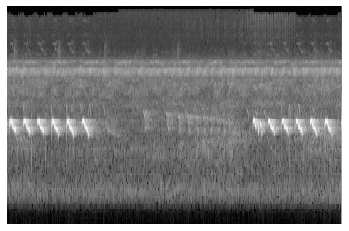

In [6]:
for i in range(len(data)): 
    imgpath = audiofiles_dir + '_images/'
    
#     #TODO: having issues with making directory on external harddrive & in Os 
#     #https://stackoverflow.com/questions/600268/mkdir-p-functionality-in-python
#     #if able to make directory without needing permissions
#     if os.path.isdir(imgpath): os.rmdir(imgpath) 
#     else: 
#         os.mkdir(imgpath)
    newimgname = os.path.splitext(filenames[i])[0]
    plot_mel_spectrogram(data[i], 44100, imgpath, filenames, i)


## Adding Noise to Images
Portions of code taken from [here](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_14_02_auto_encode.ipynb)

Rows: 906, Cols: 1395
(906, 1395, 4)


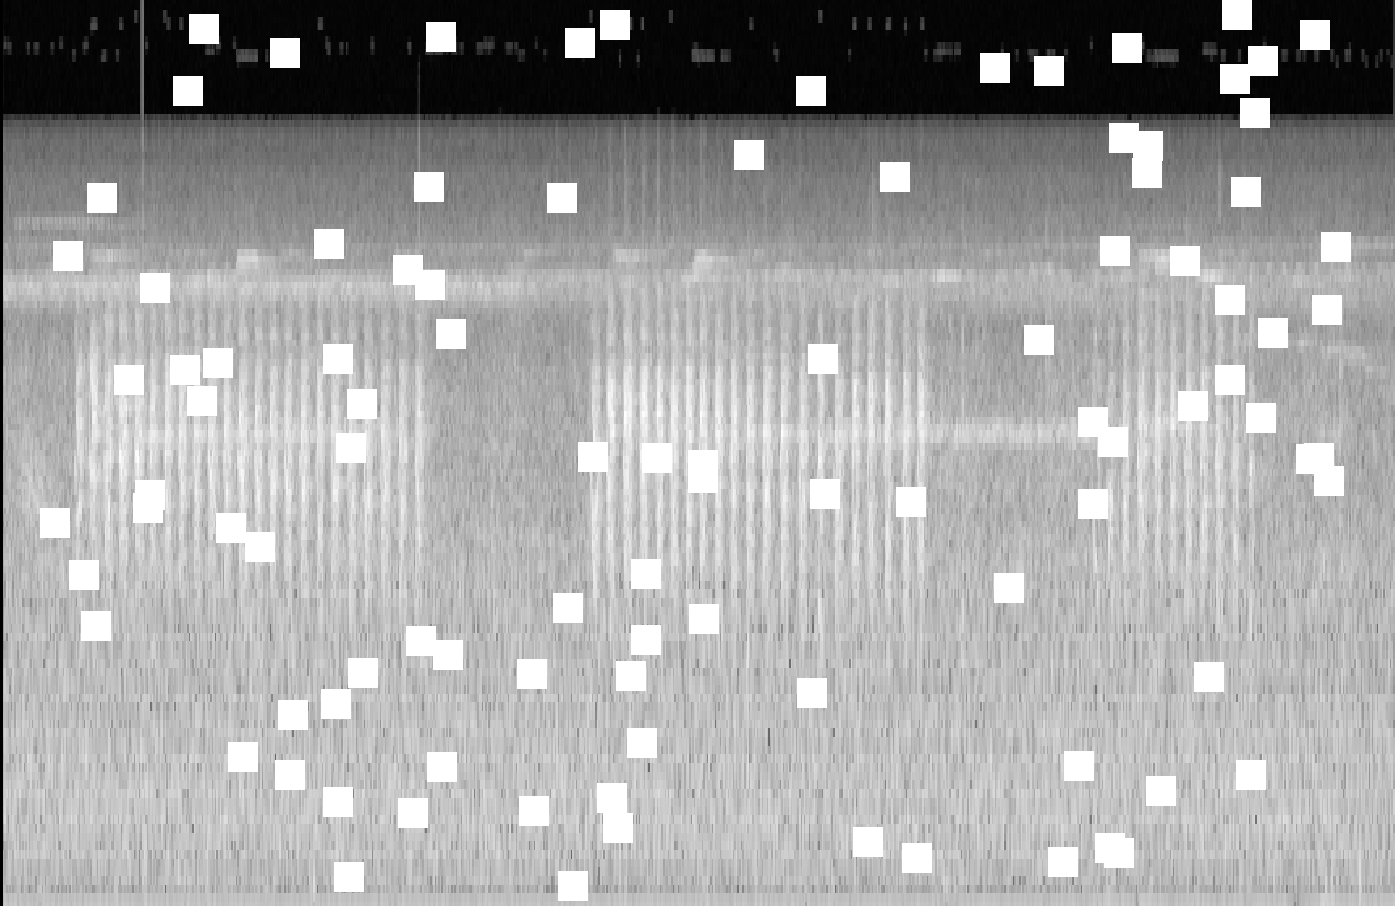

In [62]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests

%matplotlib inline

def add_noise(a):
    a2 = a.copy()
    rows = a2.shape[0]
    cols = a2.shape[1]
    s = int(min(rows,cols)/30) # size of spot is 1/20 of smallest dimension
    
    for i in range(100):
        x = np.random.randint(cols-s)
        y = np.random.randint(rows-s)
        a2[y:(y+s),x:(x+s)] = 0
        
    return a2

img = Image.open(imgpath + 'XC22404 - Black Antbird - Cercomacroides serva_0.png')
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = img_array.astype(np.uint8)
print(img2_array.shape)
img2_array = add_noise(img2_array)
img2 = Image.fromarray(img2_array)
img2

In [77]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from IPython.display import display, HTML


def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
    
x = []    
y = []
loaded_images = []

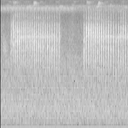

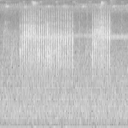

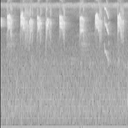

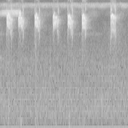

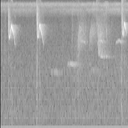

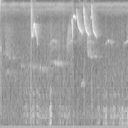

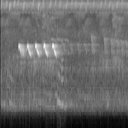

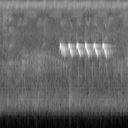

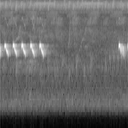

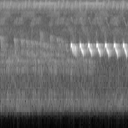

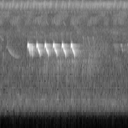

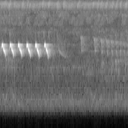

65536


In [78]:
import glob

for name in glob.glob(os.path.join(imgpath, '*.png')):
    
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    img = Image.open(name)
    img.load()
    img = make_square(img)
    img = img.resize((128,128), Image.ANTIALIAS)
    
    loaded_images.append(img)
    display(img)
    for i in range(10):
        img_array = np.asarray(img)
        img_array_noise = add_noise(img_array)
        
        img_array = img_array.flatten()
        img_array = img_array.astype(np.float32)
        img_array = (img_array-128)/128
        
        img_array_noise = img_array_noise.flatten()
        img_array_noise = img_array_noise.astype(np.float32)
        img_array_noise = (img_array_noise-128)/128
        
        x.append(img_array_noise)
        y.append(img_array)
    
x = np.array(x)
y = np.array(y)
print(x[1].size)

## Implement Denoising Autoencoder

In [65]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [66]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML 

print("Creating/Training neural network")
model = Sequential() # Each layer has exactly one input and output tensor
model.add(Dense(100, input_dim=x.shape[1], activation='relu')) # 
model.add(Dense(50, activation='relu')) # 
model.add(Dense(100, activation='relu')) # 
model.add(Dense(x.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=1,epochs=20)

print("Neural network trained")

Creating/Training neural network
Epoch 1/20
4/4 [==============================] - 0s 119ms/step - loss: 0.2695
Epoch 2/20
4/4 [==============================] - 0s 47ms/step - loss: 0.0529
Epoch 3/20
4/4 [==============================] - 0s 49ms/step - loss: 0.0341
Epoch 4/20
4/4 [==============================] - 0s 49ms/step - loss: 0.0238
Epoch 5/20
4/4 [==============================] - 0s 47ms/step - loss: 0.0169
Epoch 6/20
4/4 [==============================] - 0s 49ms/step - loss: 0.0146
Epoch 7/20
4/4 [==============================] - 0s 50ms/step - loss: 0.0127
Epoch 8/20
4/4 [==============================] - 0s 49ms/step - loss: 0.0114
Epoch 9/20
4/4 [==============================] - 0s 48ms/step - loss: 0.0112
Epoch 10/20
4/4 [==============================] - 0s 52ms/step - loss: 0.0097
Epoch 11/20
4/4 [==============================] - 0s 45ms/step - loss: 0.0099
Epoch 12/20
4/4 [==============================] - 0s 47ms/step - loss: 0.0083
Epoch 13/20
4/4 [==========

*** Trial 1
With noise:


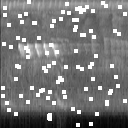

After auto encode noise removal


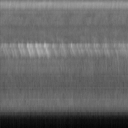

*** Trial 2
With noise:


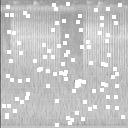

After auto encode noise removal


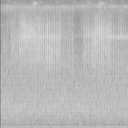

*** Trial 3
With noise:


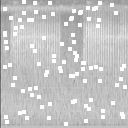

After auto encode noise removal


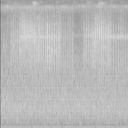

*** Trial 4
With noise:


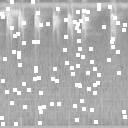

After auto encode noise removal


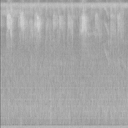

*** Trial 5
With noise:


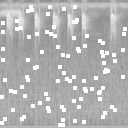

After auto encode noise removal


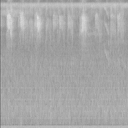

*** Trial 6
With noise:


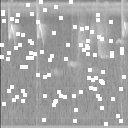

After auto encode noise removal


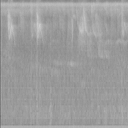

*** Trial 7
With noise:


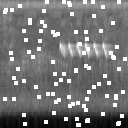

After auto encode noise removal


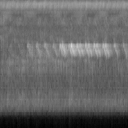

*** Trial 8
With noise:


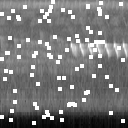

After auto encode noise removal


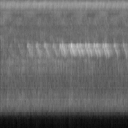

*** Trial 9
With noise:


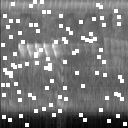

After auto encode noise removal


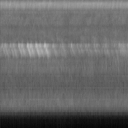

*** Trial 10
With noise:


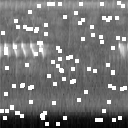

After auto encode noise removal


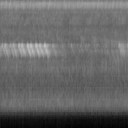

In [67]:
for z in range(10):
    print("*** Trial {}".format(z+1))
    
    # Choose random image
    i = np.random.randint(len(loaded_images))
    img = loaded_images[i]
    img_array = np.asarray(img)
    cols, rows = img.size

    # Add noise
    img_array_noise = add_noise(img_array)    

    #Display noisy image
    img2 = img_array_noise.astype(np.uint8)
    img2 = Image.fromarray(img2)
    print("With noise:")
    display(img2)

    # Present noisy image to auto encoder
    img_array_noise = img_array_noise.flatten()
    img_array_noise = img_array_noise.astype(np.float32)
    img_array_noise = (img_array_noise-128)/128
    img_array_noise = np.array([img_array_noise])
    pred = model.predict(img_array_noise)[0]
    
    # Display neural result
    img_array2 = pred.reshape(rows,cols,4)
    img_array2 = (img_array2*128)+128
    img_array2 = img_array2.astype(np.uint8)
    
    img2 = Image.fromarray(img_array2)
    img2 = img2.convert("L")
    
    print("After auto encode noise removal")
    display(img2)
    
    # TODO: Display original result after it 